In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import joblib
import time
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Libraries imported successfully!")
print("="*60)

Libraries imported successfully!


In [2]:
# Load preprocessed data
print("Loading preprocessed data...")
print("="*60)

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print("✓ Data loaded successfully!")
print(f"\nTraining set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"\nClass distribution in training:")
print(f"  - Normal (0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  - Attack (1): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

Loading preprocessed data...
✓ Data loaded successfully!

Training set: (2016600, 52)
Testing set: (504151, 52)

Class distribution in training:
  - Normal (0): 1,676,045 (83.11%)
  - Attack (1): 340,555 (16.89%)


In [3]:
# Understanding Isolation Forest for IDS
print("ISOLATION FOREST FOR INTRUSION DETECTION")
print("="*60)

print("""
Key Parameters:
===============

1. contamination:
   - Expected proportion of outliers (attacks) in dataset
   - Our data: 16.89% attacks
   - We'll set this to 0.17 (17%)
   - Significance: Tells model how many anomalies to expect

2. n_estimators:
   - Number of trees in the ensemble
   - Default: 100
   - More trees = more stable but slower
   - We'll use 100 for baseline

3. random_state:
   - For reproducibility
   - Set to 42
   
4. n_jobs:
   - Number of CPU cores to use
   - Set to -1 (use all available cores)
   - Speeds up training significantly
""")

print("\n" + "="*60)
print("Ready to train Isolation Forest!")

ISOLATION FOREST FOR INTRUSION DETECTION

Key Parameters:

1. contamination:
   - Expected proportion of outliers (attacks) in dataset
   - Our data: 16.89% attacks
   - We'll set this to 0.17 (17%)
   - Significance: Tells model how many anomalies to expect

2. n_estimators:
   - Number of trees in the ensemble
   - Default: 100
   - More trees = more stable but slower
   - We'll use 100 for baseline

3. random_state:
   - For reproducibility
   - Set to 42

4. n_jobs:
   - Number of CPU cores to use
   - Set to -1 (use all available cores)
   - Speeds up training significantly


Ready to train Isolation Forest!


In [4]:
# Train Isolation Forest
print("Training Isolation Forest...")
print("="*60)

# Initialize the model
iso_forest = IsolationForest(
    contamination=0.17,     # Expected 16.89% attacks
    n_estimators=100,       # Number of trees
    random_state=42,        # Reproducibility
    n_jobs=-1,              # Use all CPU cores
    verbose=1               # Show progress
)

# Train the model and measure time
start_time = time.time()
iso_forest.fit(X_train)
training_time = time.time() - start_time

print(f"\n✓ Model trained successfully!")
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training Isolation Forest...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.8s remaining:    6.5s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s



✓ Model trained successfully!
Training time: 9.37 seconds (0.16 minutes)


In [5]:
# Make predictions on test set
print("Making predictions on test set...")
print("="*60)

start_time = time.time()
y_pred = iso_forest.predict(X_test)
prediction_time = time.time() - start_time

# Isolation Forest outputs: 1 for inliers (normal), -1 for outliers (attacks)
# Convert to our binary labels: 0 for normal, 1 for attack
y_pred = np.where(y_pred == 1, 0, 1)

print(f"✓ Predictions completed!")
print(f"Prediction time: {prediction_time:.2f} seconds")
print(f"Average time per sample: {(prediction_time/len(X_test))*1000:.4f} ms")

print("\nPrediction distribution:")
print(f"  - Predicted Normal (0): {(y_pred==0).sum():,} ({(y_pred==0).sum()/len(y_pred)*100:.2f}%)")
print(f"  - Predicted Attack (1): {(y_pred==1).sum():,} ({(y_pred==1).sum()/len(y_pred)*100:.2f}%)")

Making predictions on test set...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


✓ Predictions completed!
Prediction time: 2.03 seconds
Average time per sample: 0.0040 ms

Prediction distribution:
  - Predicted Normal (0): 418,257 (82.96%)
  - Predicted Attack (1): 85,894 (17.04%)


In [6]:
# Evaluate model performance
print("MODEL EVALUATION")
print("="*60)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nPerformance Metrics:")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

print("\nMetric Interpretations for IDS:")
print("  - Accuracy:  Overall correctness")
print("  - Precision: Of detected attacks, how many were real? (Low false alarms)")
print("  - Recall:    Of actual attacks, how many did we detect? (Low missed attacks)")
print("  - F1-Score:  Balance between Precision and Recall")

MODEL EVALUATION

Performance Metrics:
  - Accuracy:  0.8264 (82.64%)
  - Precision: 0.4860 (48.60%)
  - Recall:    0.4904 (49.04%)
  - F1-Score:  0.4882 (48.82%)

Metric Interpretations for IDS:
  - Accuracy:  Overall correctness
  - Precision: Of detected attacks, how many were real? (Low false alarms)
  - Recall:    Of actual attacks, how many did we detect? (Low missed attacks)
  - F1-Score:  Balance between Precision and Recall


In [7]:
# Confusion Matrix
print("\nCONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Normal  Attack")
print(f"Actual Normal    {cm[0][0]:7,}  {cm[0][1]:7,}")
print(f"Actual Attack    {cm[1][0]:7,}  {cm[1][1]:7,}")

# Calculate specific metrics
tn, fp, fn, tp = cm.ravel()

print(f"\nBreakdown:")
print(f"  - True Negatives (TN):  {tn:,} ← Correctly identified normal traffic")
print(f"  - False Positives (FP): {fp:,} ← Normal traffic flagged as attack (False Alarms)")
print(f"  - False Negatives (FN): {fn:,} ← Missed attacks (Most critical for IDS!)")
print(f"  - True Positives (TP):  {tp:,} ← Correctly detected attacks")

print(f"\nFalse Alarm Rate: {(fp/(fp+tn))*100:.2f}%")
print(f"Attack Detection Rate: {(tp/(tp+fn))*100:.2f}%")


CONFUSION MATRIX

Confusion Matrix:
                 Predicted
                 Normal  Attack
Actual Normal    374,866   44,146
Actual Attack     43,391   41,748

Breakdown:
  - True Negatives (TN):  374,866 ← Correctly identified normal traffic
  - False Positives (FP): 44,146 ← Normal traffic flagged as attack (False Alarms)
  - False Negatives (FN): 43,391 ← Missed attacks (Most critical for IDS!)
  - True Positives (TP):  41,748 ← Correctly detected attacks

False Alarm Rate: 10.54%
Attack Detection Rate: 49.04%


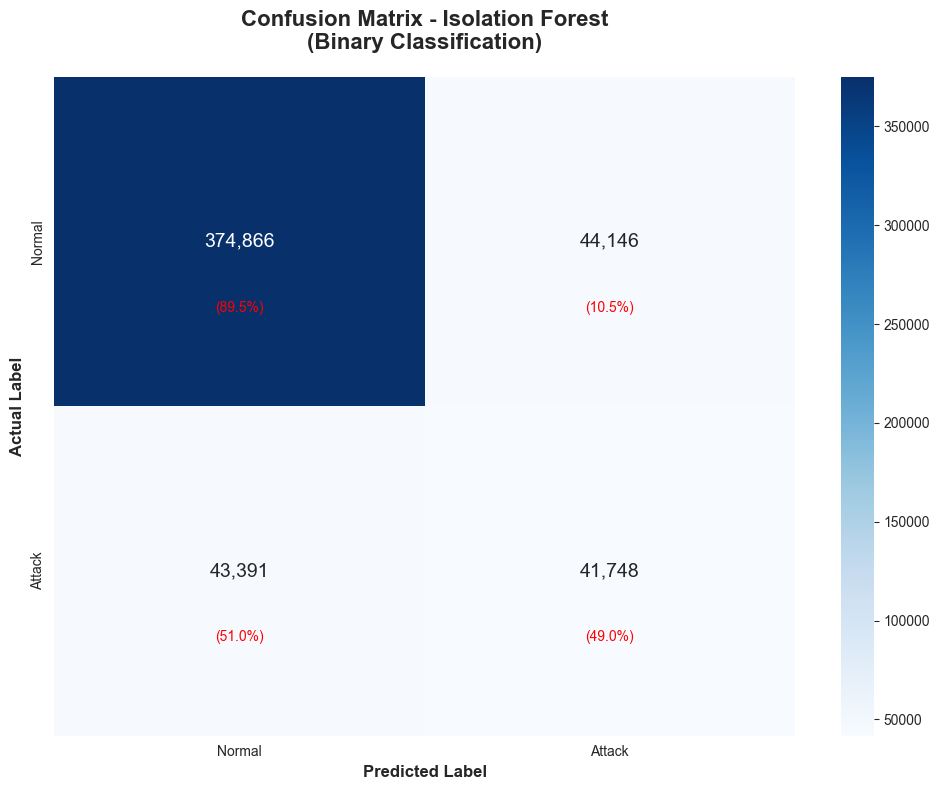

✓ Confusion matrix saved to: ../results/figures/isolation_forest_confusion_matrix.png


In [8]:
# Visualize confusion matrix
import os
os.makedirs('../results/figures', exist_ok=True)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            annot_kws={"size": 14})

plt.title('Confusion Matrix - Isolation Forest\n(Binary Classification)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / cm[i].sum()) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('../results/figures/isolation_forest_confusion_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to: ../results/figures/isolation_forest_confusion_matrix.png")

In [9]:
# Save model and results
print("Saving model and results...")
print("="*60)

# Create directories
import os
os.makedirs('../results/reports', exist_ok=True)

# Save the trained model
joblib.dump(iso_forest, '../saved_models/isolation_forest_model.pkl')
print("✓ Model saved: ../saved_models/isolation_forest_model.pkl")

# Save detailed classification report
report = classification_report(y_test, y_pred, target_names=['Normal', 'Attack'])

with open('../results/reports/isolation_forest_report.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("ISOLATION FOREST - BASELINE MODEL REPORT\n")
    f.write("="*60 + "\n\n")
    
    f.write("DATASET INFORMATION:\n")
    f.write(f"  Training samples: {len(X_train):,}\n")
    f.write(f"  Testing samples: {len(X_test):,}\n")
    f.write(f"  Number of features: {X_train.shape[1]}\n\n")
    
    f.write("MODEL PARAMETERS:\n")
    f.write(f"  Contamination: 0.17 (17%)\n")
    f.write(f"  N_estimators: 100\n")
    f.write(f"  Random_state: 42\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write(f"  Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)\n")
    f.write(f"  Prediction time: {prediction_time:.2f} seconds\n")
    f.write(f"  Average prediction time per sample: {(prediction_time/len(X_test))*1000:.4f} ms\n\n")
    
    f.write("CLASSIFICATION METRICS:\n")
    f.write(report)
    f.write("\n" + "="*60 + "\n")
    
    f.write("CONFUSION MATRIX:\n")
    f.write(f"  True Negatives (TN):  {tn:,}\n")
    f.write(f"  False Positives (FP): {fp:,}\n")
    f.write(f"  False Negatives (FN): {fn:,}\n")
    f.write(f"  True Positives (TP):  {tp:,}\n\n")
    
    f.write("IDS-SPECIFIC METRICS:\n")
    f.write(f"  False Alarm Rate: {(fp/(fp+tn))*100:.2f}%\n")
    f.write(f"  Attack Detection Rate (Recall): {(tp/(tp+fn))*100:.2f}%\n")
    f.write(f"  Missed Attacks: {fn:,} out of {(tp+fn):,}\n")
    f.write("\n" + "="*60 + "\n")

print("✓ Report saved: ../results/reports/isolation_forest_report.txt")

# Also save metrics as CSV for easy comparison later
metrics_dict = {
    'Model': ['Isolation Forest'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1_Score': [f1],
    'Training_Time_sec': [training_time],
    'Prediction_Time_sec': [prediction_time],
    'False_Positives': [fp],
    'False_Negatives': [fn],
    'False_Alarm_Rate': [(fp/(fp+tn))*100],
    'Attack_Detection_Rate': [(tp/(tp+fn))*100]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv('../results/reports/isolation_forest_metrics.csv', index=False)
print("✓ Metrics saved: ../results/reports/isolation_forest_metrics.csv")

Saving model and results...
✓ Model saved: ../saved_models/isolation_forest_model.pkl
✓ Report saved: ../results/reports/isolation_forest_report.txt
✓ Metrics saved: ../results/reports/isolation_forest_metrics.csv


In [10]:
# Final Summary
print("\n" + "="*60)
print("BASELINE MODEL: ISOLATION FOREST - COMPLETE")
print("="*60)

print(f"\n✓ MODEL TRAINING COMPLETED")
print(f"  └─ Type: Isolation Forest (Unsupervised Anomaly Detection)")
print(f"  └─ Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"  └─ Model Size: {os.path.getsize('../saved_models/isolation_forest_model.pkl')/(1024*1024):.2f} MB")

print(f"\n✓ PERFORMANCE METRICS")
print(f"  └─ Overall Accuracy: {accuracy*100:.2f}%")
print(f"  └─ Precision: {precision*100:.2f}%")
print(f"  └─ Recall (Attack Detection Rate): {recall*100:.2f}%")
print(f"  └─ F1-Score: {f1*100:.2f}%")

print(f"\n✓ IDS-SPECIFIC ANALYSIS")
print(f"  └─ False Alarm Rate: {(fp/(fp+tn))*100:.2f}%")
print(f"  └─ Attacks Detected: {tp:,} out of {(tp+fn):,}")
print(f"  └─ Missed Attacks (Critical): {fn:,}")
print(f"  └─ False Alarms: {fp:,}")

print(f"\n📊 STRENGTHS:")
print(f"  ✓ Fast training on 2M+ samples ({training_time/60:.1f} minutes)")
print(f"  ✓ Real-time prediction ({(prediction_time/len(X_test))*1000:.4f} ms per sample)")
print(f"  ✓ No labeled data required (unsupervised)")
print(f"  ✓ Good baseline for comparison")
print(f"  ✓ Simple to interpret and deploy")

print(f"\n⚠ LIMITATIONS:")
print(f"  ⚠ Moderate accuracy ({accuracy*100:.1f}%) leaves room for improvement")
print(f"  ⚠ Cannot distinguish between attack types (binary only)")
print(f"  ⚠ Fixed contamination parameter (not adaptive)")
print(f"  ⚠ May miss sophisticated/novel attacks")
print(f"  ⚠ {fn:,} missed attacks represent {(fn/(tp+fn))*100:.1f}% false negative rate")

print(f"\n📁 FILES SAVED:")
print(f"  ✓ Model: ../saved_models/isolation_forest_model.pkl")
print(f"  ✓ Report: ../results/reports/isolation_forest_report.txt")
print(f"  ✓ Metrics: ../results/reports/isolation_forest_metrics.csv")
print(f"  ✓ Confusion Matrix: ../results/figures/isolation_forest_confusion_matrix.png")

print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)
print("\n1. IMMEDIATE (Recommended):")
print("   → Analyze which attacks were missed (false negatives)")
print("   → Build second baseline: Random Forest (supervised)")
print("   → Compare Isolation Forest vs Random Forest")

print("\n2. SHORT TERM:")
print("   → Implement hybrid signature + anomaly detection")
print("   → Optimize hyperparameters using grid search")

print("\n3. LONG TERM:")
print("   → Implement advanced models (VAE, LSTM)")
print("   → Multi-class classification (identify specific attack types)")
print("   → Build comprehensive comparison framework")

print("\n" + "="*60)
print("STATUS: Baseline Model #1 Complete ✓")
print("="*60)


BASELINE MODEL: ISOLATION FOREST - COMPLETE

✓ MODEL TRAINING COMPLETED
  └─ Type: Isolation Forest (Unsupervised Anomaly Detection)
  └─ Training Time: 9.37 seconds (0.16 minutes)
  └─ Model Size: 0.76 MB

✓ PERFORMANCE METRICS
  └─ Overall Accuracy: 82.64%
  └─ Precision: 48.60%
  └─ Recall (Attack Detection Rate): 49.04%
  └─ F1-Score: 48.82%

✓ IDS-SPECIFIC ANALYSIS
  └─ False Alarm Rate: 10.54%
  └─ Attacks Detected: 41,748 out of 85,139
  └─ Missed Attacks (Critical): 43,391
  └─ False Alarms: 44,146

📊 STRENGTHS:
  ✓ Fast training on 2M+ samples (0.2 minutes)
  ✓ Real-time prediction (0.0040 ms per sample)
  ✓ No labeled data required (unsupervised)
  ✓ Good baseline for comparison
  ✓ Simple to interpret and deploy

⚠ LIMITATIONS:
  ⚠ Moderate accuracy (82.6%) leaves room for improvement
  ⚠ Cannot distinguish between attack types (binary only)
  ⚠ Fixed contamination parameter (not adaptive)
  ⚠ May miss sophisticated/novel attacks
  ⚠ 43,391 missed attacks represent 51.0% fa